In [3]:
from google.colab import drive
from pyspark.sql import SparkSession
drive.mount("/content/drive")
!pip install fastdtw
!pip install PySpark


# Initialize Spark session
spark = SparkSession.builder \
    .appName("DTW Parallel") \
    .config("spark.master", "local[*]") \
    .getOrCreate()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


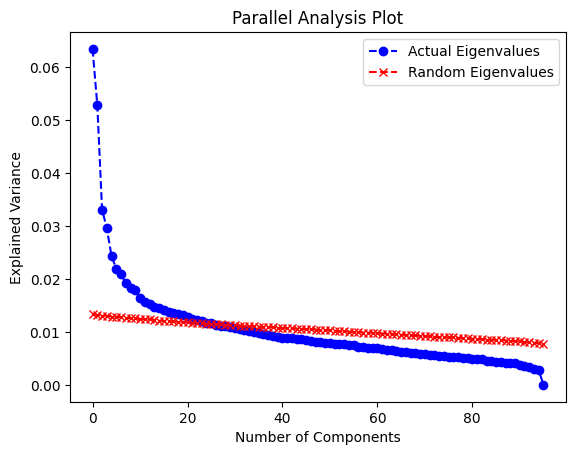

Number of PC extracted using PA: 26
Elapsed Time for preprocessing and PCA with PA: 122.63035082817078 seconds


In [4]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import rand
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler ,StandardScaler, PCA
from fastdtw import fastdtw
import numpy as np
import pandas as pd
import scipy.io.arff as arff
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.sql.functions import monotonically_increasing_id
import time



###################### Loading and pre-processing ##########################

# Start the timer
start_time = time.time()

# Load data into Spark DataFrames
load_train = arff.loadarff('/content/drive/MyDrive/ElectricDevices_TRAIN.arff')
load_test = arff.loadarff("/content/drive/MyDrive/ElectricDevices_TEST.arff")

tr = pd.DataFrame(load_train[0])
tst = pd.DataFrame(load_test[0])

# Convert Pandas DataFrame to Spark DataFrame
train_df = spark.createDataFrame(tr)
test_df = spark.createDataFrame(tst)


# Get feature names iterator
features = train_df.drop("target").columns

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=features, outputCol="features")
assembled_train = assembler.transform(train_df)
assembled_test = assembler.transform(test_df)

# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
#Fit scaler using train data, then apply to both df, prevent bias
scaler_model = scaler.fit(assembled_train)
scaled_train = scaler_model.transform(assembled_train)
scaled_test = scaler_model.transform(assembled_test)

#Perform PCA with all features
pca = PCA(k=len(features), inputCol="scaled_features", outputCol="pca_features")
# Fit PCA on the training set
pca_model = pca.fit(scaled_train)

# Extract explained variance ratio from the PCA model
explained_variance_ratio = pca_model.explainedVariance.toArray()

# Initialize an array to store the averaged eigenvalues from random datasets
random_eigenvalues = np.zeros(len(explained_variance_ratio))

# Number of random datasets
num_random_datasets = 20

# Generate random datasets and compute eigenvalues for each
for i in range(num_random_datasets):
    # Generate random data similar to scaled_train
    random_data = scaled_train.select("scaled_features").rdd.map(lambda row: row[0]).map(lambda x: (Vectors.dense(np.random.normal(0, 1, len(x))),)).toDF(["scaled_features"])

    # Fit PCA on random data
    pca_random_model = pca.fit(random_data)

    # Extract explained variance ratio and accumulate
    random_eigenvalues += pca_random_model.explainedVariance.toArray()


# Average eigenvalues of random
random_eigenvalues /= num_random_datasets

# Plot parallel analysis
plt.plot(explained_variance_ratio, '--bo', label='Actual Eigenvalues')
plt.plot(random_eigenvalues, '--rx', label='Random Eigenvalues')
plt.legend()
plt.title('Parallel Analysis Plot')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.show()

# Define the number of components as the number of features with higher variance ratio than random
num_components = len([i for i, evr in enumerate(explained_variance_ratio) if evr > random_eigenvalues[i]])
print("Number of PC extracted using PA:", num_components)

# Perform PCA with the selected number of components
pca = PCA(k=num_components, inputCol="scaled_features", outputCol="pca_features")

# Fit PCA on the training set
pca_model = pca.fit(scaled_train)

# Transform the training and test sets
train_pca = pca_model.transform(scaled_train).select(["pca_features","target"]).withColumnRenamed("pca_features","pca_features_train")
test_pca = pca_model.transform(scaled_test).select(["pca_features", "target"]).withColumnRenamed("pca_features","pca_features_test")

# Create id columns
train = train_pca.withColumn("train_id", monotonically_increasing_id())
test = test_pca.withColumn("test_id", monotonically_increasing_id())

# Convert the "target" column from bytearray to string
train = train.withColumn("target", train["target"].cast("string"))
test = test.withColumn("target", test["target"].cast("string"))

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Elapsed Time for preprocessing and PCA with PA:", elapsed_time, "seconds")

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col, explode, broadcast, count, desc, row_number
from pyspark.ml.feature import BucketedRandomProjectionLSH
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row, functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import StringIndexer, IndexToString
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import warnings

# Suppress warnings due to zero divisions when calculating metrics
warnings.filterwarnings("ignore")

############################  Data Sampling ######################################################
# If true return a sample of data, otherwise full data set
def get_data(train, test, testing):
  if testing:
      n_train = 1000
      n_test = 1000
  else:
    n_train = train.count() # 8926 rows
    n_test = test.count() # 7711 rows

  X_train = train.limit(n_train).select(["pca_features_train", "train_id"])
  y_train = train.limit(n_train).select(["target", "train_id"])

  X_test = test.limit(n_test).select(["pca_features_test", "test_id"])
  y_test = test.limit(n_test).select(["target", "test_id"])

  return X_train, y_train, X_test, y_test

################################################# KNN with DTW definition ###############################################################

# Define a custom distance function using DTW
def dtw(row):
  #Row(test=Row(pca_features_test=DenseVector([-5.217, 3.0353]), test_id=0), train=Row(pca_features_train=DenseVector([1.3094, 2.0754]), train_id=0))
    distance, _ = fastdtw(row[0]["pca_features_test"], row[1]["pca_features_train"])
    return [distance, row[1]["train_id"],row[0]["test_id"]]

def knn_predict(train, X_train, y_train, X_test, k):

     # Calculate DTW distance for all test train combinations
    cartesian_df = X_test.rdd.cartesian(X_train.rdd).map(lambda x: dtw(x)).toDF(["distance", "train_id", "test_id"])

    # Partition by test_id and rank distances within each partition
    window_spec = Window.partitionBy("test_id").orderBy("distance")
    ranked_df = cartesian_df.withColumn("rank", row_number().over(window_spec))

    # Filter to keep only the top k nearest neighbors for each test point
    k_nearest_neighbors_df = ranked_df.filter(ranked_df["rank"] <= k).drop("rank")

    # Add an alias to the train DataFrame
    train_alias = train.select("train_id", "target").withColumnRenamed("target", "neighbor_target").alias("train_alias")

    # Join with the original DataFrame to retrieve the targets of the neighbors
    predictions_df = k_nearest_neighbors_df.join(train_alias, on=k_nearest_neighbors_df["train_id"] == train_alias["train_alias.train_id"], how="inner")

    # Group by test_id and collect the targets of k nearest neighbors for each test point
    predictions_df = predictions_df.groupBy("test_id").agg(F.collect_list("neighbor_target").alias("neighbor_targets"))

    # Define a UDF to determine the majority class
    majority_class_udf = F.udf(lambda neighbors: max(set(neighbors), key=neighbors.count), F.StringType())

    # Apply the majority class UDF to predict the label for each test point
    predictions_df = predictions_df.withColumn("predicted_label", majority_class_udf(predictions_df["neighbor_targets"]))

    # Select the test_id and predicted_label columns
    predictions_df = predictions_df.select("test_id", "predicted_label")

    return predictions_df



######################## KNN using SKLEARN for validation #############################################
# DTW to be used with sklearn knn
def dtw_distance(X, Y):
  distance, _ = fastdtw(X, Y)
  return distance

def sklearn_knn(X_train, y_train, X_test, y_test, k):
  #Start timer
  start_time = time.time()

  # Collect the features and labels from Spark DataFrames into local lists
  X_train = np.concatenate(X_train.select("pca_features_train").collect(), axis=0)
  X_test = np.concatenate(X_test.select("pca_features_test").collect(), axis=0)

  y_train = np.concatenate(y_train.select("target").collect(), axis=0)
  y_test = np.concatenate(y_test.select("target").collect(), axis=0)

  # Reshape the feature arrays to 2D
  X_train = X_train.reshape((X_train.shape[0], -1))
  X_test = X_test.reshape((X_test.shape[0], -1))

  # Reshape the label arrays to 1D
  y_train = y_train.reshape(-1)
  y_test = y_test.reshape(-1)

  # Create an instance of KNeighborsClassifier with custom DTW distance function
  knn = KNeighborsClassifier(n_neighbors=k, metric=dtw_distance)

  # Train the KNN classifier on the training data
  knn.fit(X_train, y_train)

  # Obtain predictions for the test data
  y_pred = knn.predict(X_test)

  # Use classification_report to generate a report
  report = classification_report(y_test, y_pred, output_dict=True)

  # Print the weighted average metrics
  weighted_avg_precision = report['weighted avg']['precision']
  weighted_avg_recall = report['weighted avg']['recall']
  weighted_avg_f1_score = report['weighted avg']['f1-score']


  print(f"Precision: {weighted_avg_precision}")
  print(f"Recall: {weighted_avg_recall}")
  print(f"F1-score: {weighted_avg_f1_score}")

  # Calculate balanced accuracy
  balanced_acc = balanced_accuracy_score(y_test, y_pred)
  print(f"Balanced Accuracy: {balanced_acc}")


  # Stop the timer
  end_time = time.time()
  # Calculate the elapsed time
  elapsed_time = end_time - start_time
  print("Elapsed Time:", elapsed_time, "seconds")


####################################################  Evaluation  method ##############################################################################


def evaluate(train, X_train, y_train, X_test, y_test, k):
  # Start the timer
  start_time = time.time()

  # Custom KNN with DTW
  pred = knn_predict(train, X_train, y_train, X_test, k)

  predictions_and_labels = pred.join(y_test, on ="test_id", how="inner")

  # Convert Spark DataFrame columns to lists or arrays
  y_true = predictions_and_labels.select("target").rdd.flatMap(lambda x: x).collect()
  y_pred = predictions_and_labels.select("predicted_label").rdd.flatMap(lambda x: x).collect()

  # Use classification_report to generate a report
  report = classification_report(y_true, y_pred, output_dict=True)

  # Print confusion matrix
  print("Confusion Matrix:")
  print(confusion_matrix(y_true, y_pred))

  # Print the weighted average metrics
  weighted_avg_precision = report['weighted avg']['precision']
  weighted_avg_recall = report['weighted avg']['recall']
  weighted_avg_f1_score = report['weighted avg']['f1-score']

  print(f"Precision: {weighted_avg_precision}")
  print(f"Recall: {weighted_avg_recall}")
  print(f"F1-score: {weighted_avg_f1_score}")

  # Calculate balanced accuracy
  balanced_acc = balanced_accuracy_score(y_true, y_pred)
  print(f"Balanced Accuracy: {balanced_acc}")

  # Stop the timer
  end_time = time.time()

  # Calculate the elapsed time
  elapsed_time = end_time - start_time

  print("Elapsed Time:", elapsed_time, "seconds")

In [11]:
################################## Tests ##############################################
# Test both models on subset of data to compare perfomance and see if same results are obtained
def test_models(train, test, k, testing):
  print("\nKneighbors:", k)

  X_train, y_train, X_test, y_test = get_data(train, test, testing)

  print("\nCustom knn:")
  evaluate(train, X_train, y_train, X_test, y_test, k)

  print("\nSklearn knn:")
  sklearn_knn(X_train, y_train, X_test, y_test, k)

In [87]:
#Run models on a subset of the data
test_models(train, test, k=10, testing=True)


Kneighbors: 10

Custom knn:
Confusion Matrix:
[[ 62   1  63  50   0   0]
 [  0   0   0   0   0   0]
 [  3  45 198  15   0   0]
 [ 49   4  78  72   0   0]
 [ 67  57  92  22   0   0]
 [ 11   2 104   5   0   0]]
Precision: 0.24254967707621003
Recall: 0.332
F1-score: 0.2687997950896528
Balanced Accuracy: 0.29311464397671294
Elapsed Time: 181.66223430633545 seconds

Sklearn knn:
Precision: 0.2440101644586569
Recall: 0.325
F1-score: 0.2643636613193046
Balanced Accuracy: 0.28732833258695323
Elapsed Time: 75.61997151374817 seconds


In [88]:
# Run models on a subset of the data
test_models(train, test, k=5, testing=True)


Kneighbors: 5

Custom knn:
Confusion Matrix:
[[ 67   1  47  61   0   0]
 [  0   0   0   0   0   0]
 [  2  38 210  11   0   0]
 [ 51   4  64  84   0   0]
 [ 69  53  81  35   0   0]
 [ 13   1  89  19   0   0]]
Precision: 0.2512055655260027
Recall: 0.361
F1-score: 0.29073908217371974
Balanced Accuracy: 0.31981452455590387
Elapsed Time: 182.54745078086853 seconds

Sklearn knn:
Precision: 0.26459193374679096
Recall: 0.365
F1-score: 0.2967903481382932
Balanced Accuracy: 0.32489675075881974
Elapsed Time: 73.90063858032227 seconds


In [89]:
# Run models on a subset of the data
test_models(train, test, k=50, testing=True)


Kneighbors: 50

Custom knn:
Confusion Matrix:
[[ 36   4  98  38   0   0]
 [  0   0   0   0   0   0]
 [  0  92 156  13   0   0]
 [ 37   8 112  46   0   0]
 [ 57  64 102  15   0   0]
 [  2   4 114   2   0   0]]
Precision: 0.19987104358835234
Recall: 0.238
F1-score: 0.1966555484099631
Balanced Accuracy: 0.20576951783848338
Elapsed Time: 179.3695650100708 seconds

Sklearn knn:
Precision: 0.201481234479404
Recall: 0.238
F1-score: 0.19686692257683533
Balanced Accuracy: 0.20592065979997015
Elapsed Time: 74.93346405029297 seconds


In [12]:
# Run models on a subset of the data
test_models(train, test, k=3, testing=True)


Kneighbors: 3

Custom knn:
Confusion Matrix:
[[ 68   0  48  60   0   0]
 [  0   0   0   0   0   0]
 [  3  35 215   8   0   0]
 [ 52   3  61  87   0   0]
 [ 71  53  74  40   0   0]
 [ 20   2  76  24   0   0]]
Precision: 0.25495514521066526
Recall: 0.37
F1-score: 0.29776965832632724
Balanced Accuracy: 0.3277379708414191
Elapsed Time: 219.44442081451416 seconds

Sklearn knn:
Precision: 0.26460629580880124
Recall: 0.372
F1-score: 0.3021098609551496
Balanced Accuracy: 0.3307664079215803
Elapsed Time: 79.74341320991516 seconds


In [ ]:
# Get full dataset
X_train, y_train, X_test, y_test = get_data(train, test, testing=False)

print("\nSklearn knn using full dataset:")
sklearn_knn(X_train, y_train, X_test, y_test, k=5)


Sklearn knn using full dataset:
